In [1]:
import glob
import re
import numpy as np
import pandas as pd
import clima_anom as ca
from netCDF4 import Dataset

import matplotlib.pyplot as plt

import matplotlib.cbook
import matplotlib.gridspec as gridspec

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

### Extract rainfall value to one specific time and position

In [2]:
# datetime_input = [year, month, day, hour, minute, latitude, longitude]
datetime_input = ['2021', '01', '08', '09', '18', '1', '-68.2']

In [3]:
# Define the path to the data and list files
path = '/mnt/Data/Data/IMERG/raw_half_hour/'
format_files = '*.nc'

IMERG_list = glob.glob(path + format_files)
IMERG_list = sorted(IMERG_list)
IMERG_files_number = len(IMERG_list)
print(f'IMERG files number: {IMERG_files_number}')

IMERG files number: 384


In [4]:
# Create a DataFrame of dates to IMERG and export
time_tmp = []
for t in range(IMERG_files_number):

    IMERG_list_clear = IMERG_list[t].split('/')[-1].split('.')[1]

    year = IMERG_list_clear.split('-')[0][:4]
    month = IMERG_list_clear.split('-')[0][4:6]
    day = IMERG_list_clear.split('-')[0][6:8]

    hour = IMERG_list_clear.split('-')[1][1:3]
    minute = IMERG_list_clear.split('-')[1][3:5]

    time_tmp.append([year, month, day, hour, minute, IMERG_list[t].split('/')[-1]])

IMERG_times = pd.DataFrame(time_tmp, columns=['year', 'month', 'day', 'hour', 'minute', 'filename'])
IMERG_times.head(5)

# Export IMERG times to csv
IMERG_times.to_csv('../../list/IMERG_times.csv', index=False)

In [5]:
# Find the closest IMERG file from the datetime_input
# If minute is lower than 15 the minute nearest is 0 in order case is 30
print(f'Input time        : {datetime_input[0:-2]}')

IMERG_tmp = IMERG_times[
    (IMERG_times['year'] == str(datetime_input[0]).zfill(4)) & 
    (IMERG_times['month'] == str(datetime_input[1]).zfill(2)) &
    (IMERG_times['day'] == str(datetime_input[2]).zfill(2)) &
    (IMERG_times['hour'] == str(datetime_input[3]).zfill(2))
    ]

if int(datetime_input[4]) < 15: #minute condition
    IMERG_tmp = IMERG_tmp[IMERG_tmp['minute'] == '00']
else:
    IMERG_tmp = IMERG_tmp[IMERG_tmp['minute'] == '30']

near_time = [IMERG_tmp['year'].values[0],IMERG_tmp['month'].values[0],IMERG_tmp['day'].values[0],IMERG_tmp['hour'].values[0],IMERG_tmp['minute'].values[0]]

near_file = IMERG_tmp['filename'].values[0]

print(f'Nearest IMERG time: {near_time}')
print(f'Nearest IMERG file: {near_file}')

Input time        : ['2021', '01', '08', '09', '18']
Nearest IMERG time: ['2021', '01', '08', '09', '30']
Nearest IMERG file: 3IMERG.20210108-S093000-E095959.0570.V06B.nc


In [6]:
# Define a function to find the closest IMERG lat/lon point
def closest_node(serie,point):
    dist_2 = (serie - point)**2
    return np.argmin(dist_2)

In [7]:
# Extract rainfall data from the nearest IMERG file
data = ca.read_netcdf(path + near_file,0)
lat = data['lat'].data
lon = data['lon'].data
pre = data['precipitationCal'].data[0,:,:].T #The original IMERG data is transposed

nlat, nlon = len(lat), len(lon)
lon2d, lat2d = np.meshgrid(lon, lat)

In [8]:
def find_export_point(lat_data,lon_data,lat_point,lon_point):

    lat_point = float(lat_point)
    lon_point = float(lon_point)

    lat_index = closest_node(np.round(lat_data,3), float(lat_point))
    lon_index = closest_node(np.round(lon_data,3), float(lon_point))

    salida = np.zeros([1,5])
    salida[0,0] = lat_data[lat_index]
    salida[0,1] = lon_data[lon_index]
    salida[0,2] = lat_point
    salida[0,3] = lon_point
    salida[0,4] = pre[lat_index,lon_index]

    # IMERG_ = pd.DataFrame(salida, columns=['lat_IMERG', 'lon_IMERG', 'lat_point', 'lon_point', 'pre'])

    return salida

In [9]:
# Results
find_export_point(lat,lon,datetime_input[5],datetime_input[6])

array([[  1.04999995, -68.15000153,   1.        , -68.2       ,
          0.14435188]])

/home/arturo/anaconda3/envs/AXE/lib/python3.9/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


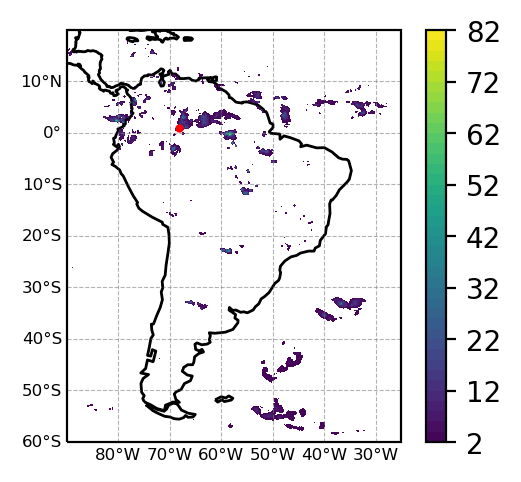

In [10]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

pre_level = np.arange(2,np.max(pre),2)

fig = plt.figure(figsize=(7,6),dpi=200)
gs = gridspec.GridSpec(2,2)

ax1 = plt.subplot(gs[0,0], projection = proj)
ax1.coastlines()
ax1.add_feature(cfeature.COASTLINE,linewidth=0.5,color='black',zorder=4)
a1 = ax1.contourf(lon2d, lat2d, pre, levels=pre_level)
bar1 = plt.colorbar(a1)

gl = ax1.gridlines(crs = proj,draw_labels=True,linewidth=0.4,color='gray',alpha=0.6,linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.xlabel_style = {'size': 6, 'color': 'black'}
gl.ylabel_style = {'size': 6, 'color': 'black'}

ax1.plot(float(datetime_input[6]), float(datetime_input[5]), 'o', color='red', markersize=2, transform=ccrs.Geodetic())

### Extract rainfall value for a group times and positions

In [35]:
# Load IMERG_times.to_csv
IMERG_times = pd.read_csv('../../list/IMERG_times.csv')
IMERG_times.head(5)

,year,month,day,hour,minute,filename
0,2021,1,1,0,0,3IMERG.20210101-S000000-E002959.0000.V06B.nc
1,2021,1,1,0,30,3IMERG.20210101-S003000-E005959.0030.V06B.nc
2,2021,1,1,1,0,3IMERG.20210101-S010000-E012959.0060.V06B.nc
3,2021,1,1,1,30,3IMERG.20210101-S013000-E015959.0090.V06B.nc
4,2021,1,1,2,0,3IMERG.20210101-S020000-E022959.0120.V06B.nc


In [36]:
# Load csv with times and positions to find
data_input = pd.read_csv('../../list/points_to_find.csv')
data_input.head(5)

,year,month,day,hour,minute,latitude,longitude
0,2021,1,8,1,0,2,-62
1,2021,1,8,1,25,2,-62
2,2021,1,8,2,10,2,-62
3,2021,1,8,2,35,2,-62
4,2021,1,8,3,0,2,-62


In [51]:
# Find the closest IMERG file from the datetime_input and extract nearest point
tt = 1

info_final = []

for tt in range(len(data_input)):

    print(f'Point       : {tt}')
    print('Input time  :',(data_input.loc[tt]['year']),data_input.loc[tt]['month'],data_input.loc[tt]['day'],data_input.loc[tt]['hour'],data_input.loc[tt]['minute'])
    IMERG_tmp = IMERG_times[
        (IMERG_times['year'] == data_input.loc[tt]['year']) & 
        (IMERG_times['month'] == data_input.loc[tt]['month']) &
        (IMERG_times['day'] == data_input.loc[tt]['day']) &
        (IMERG_times['hour'] == data_input.loc[tt]['hour'])
        ]

    if int(data_input.loc[tt]['minute']) < 15: #minute condition
        IMERG_tmp = IMERG_tmp[IMERG_tmp['minute'] == 0]
    else:
        IMERG_tmp = IMERG_tmp[IMERG_tmp['minute'] == 30]

    near_time = [IMERG_tmp['year'].values[0],IMERG_tmp['month'].values[0],IMERG_tmp['day'].values[0],IMERG_tmp['hour'].values[0],IMERG_tmp['minute'].values[0]]

    near_file = IMERG_tmp['filename'].values[0]

    print(f'Nearest time: {near_time}')
    print('File        :',IMERG_tmp['filename'].values[0])
    print()

    data = ca.read_netcdf(path + near_file,0)
    lat = data['lat'].data
    lon = data['lon'].data
    pre = data['precipitationCal'].data[0,:,:].T #The original IMERG data is transposed

    nlat, nlon = len(lat), len(lon)
    lon2d, lat2d = np.meshgrid(lon, lat)

    salida_tmp = find_export_point(lat,lon,data_input.loc[tt]['latitude'],data_input.loc[tt]['longitude'])

    info_final.append(salida_tmp)

points_info = pd.DataFrame(np.array(info_final)[:,0,:], columns=['lat_IMERG', 'lon_IMERG', 'lat_point', 'lon_point', 'pre'])

# points_info.to_csv('../../list/group_points_info.csv', index=False)

Point       : 0
Input time  : 2021 1 8 1 0
Nearest time: [2021, 1, 8, 1, 0]
File        : 3IMERG.20210108-S010000-E012959.0060.V06B.nc

Point       : 1
Input time  : 2021 1 8 1 25
Nearest time: [2021, 1, 8, 1, 30]
File        : 3IMERG.20210108-S013000-E015959.0090.V06B.nc

Point       : 2
Input time  : 2021 1 8 2 10
Nearest time: [2021, 1, 8, 2, 0]
File        : 3IMERG.20210108-S020000-E022959.0120.V06B.nc

Point       : 3
Input time  : 2021 1 8 2 35
Nearest time: [2021, 1, 8, 2, 30]
File        : 3IMERG.20210108-S023000-E025959.0150.V06B.nc

Point       : 4
Input time  : 2021 1 8 3 0
Nearest time: [2021, 1, 8, 3, 0]
File        : 3IMERG.20210108-S030000-E032959.0180.V06B.nc

Point       : 5
Input time  : 2021 1 8 3 45
Nearest time: [2021, 1, 8, 3, 30]
File        : 3IMERG.20210108-S033000-E035959.0210.V06B.nc

Point       : 6
Input time  : 2021 1 8 4 1
Nearest time: [2021, 1, 8, 4, 0]
File        : 3IMERG.20210108-S040000-E042959.0240.V06B.nc

Point       : 7
Input time  : 2021 1 8 4 